In [ ]:
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib widget

In [18]:
filepath = r"../Data/Dataset of weighing station temperature measurements.csv"

In [19]:
def convert_datetime(time_pts: pd.core.series.Series) -> np.array:
    return np.array(time_pts, dtype='datetime64[m]')

In [20]:
df = pd.read_csv(filepath, sep=';')
df[1]

,Time,Outdoor temperature [deg. C],Outdoor relative humidity [%],T[degC]-Low-S1,T[degC]-Low-S2,T[degC]-Low-S3,T[degC]-Low-S4,T[degC]-Low-S5,T[degC]-Low-S6,T[degC]-Low-S7,...,T[degC]-Top-S20,T[degC]-Top-S21,T[degC]-Top-S22,T[degC]-Top-S23,T[degC]-Top-S24,T[degC]-Top-S25,T[degC]-Top-S26,T[degC]-Top-S27,T[degC]-Top-S28,T[degC]-Top-S29
0,2023-12-21 12:10,-3.883333,42.333333,33.522705,31.560910,34.793104,30.900530,NaN,22.404998,33.093054,...,8.361203,14.383413,8.152400,11.794627,0.243417,-0.262979,0.135317,0.686731,-0.371935,0.519350
1,2023-12-21 12:12,-3.880000,42.400000,33.803224,31.345106,35.152043,30.010469,NaN,20.637749,32.470107,...,7.510757,13.676871,8.008640,11.373162,-0.190435,-0.432580,-0.057492,0.495419,-0.384059,0.387556
2,2023-12-21 12:14,-3.876667,42.466667,33.184819,30.096022,32.640345,28.717193,NaN,19.941584,31.789397,...,8.691577,14.843329,8.229449,11.859397,0.781753,-0.493263,0.411335,1.067664,-0.335581,0.614961
3,2023-12-21 12:16,-3.873333,42.533333,33.534186,31.024726,33.257158,29.600942,NaN,21.224968,31.869777,...,10.831607,16.998668,10.048923,13.826938,2.526770,0.913081,2.549498,2.620016,-0.178265,1.800967
4,2023-12-21 12:18,-3.870000,42.600000,34.166208,32.214443,34.975090,31.081814,NaN,22.437115,32.675023,...,10.396931,16.572248,9.798096,13.483880,2.187975,0.471456,1.553302,2.059153,-0.190359,1.612425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54043,2024-03-05 13:36,10.200000,62.800000,16.700229,17.126557,16.732207,16.561648,NaN,15.975155,16.572309,...,NaN,16.188466,15.719105,16.849455,NaN,16.892088,NaN,NaN,14.672450,16.348417
54044,2024-03-05 13:38,10.216667,62.733333,16.753525,17.083928,16.625610,16.657590,NaN,15.953820,16.444375,...,NaN,16.188466,15.697764,16.838796,NaN,16.924063,NaN,NaN,14.661758,16.401729
54045,2024-03-05 13:40,10.233333,62.666667,16.796161,17.083928,16.657590,16.689569,NaN,15.964487,16.508342,...,NaN,16.199130,15.655078,16.806820,NaN,16.945379,NaN,NaN,14.661758,16.327092
54046,2024-03-05 13:42,10.250000,62.600000,16.806820,17.158528,16.646930,16.614949,NaN,15.953820,16.572309,...,NaN,16.167137,15.697764,16.849453,NaN,16.913405,NaN,NaN,14.640375,16.305766


In [21]:
xdata_lbl = 'Time'
ydata_lbl = 'Outdoor temperature [deg. C]'

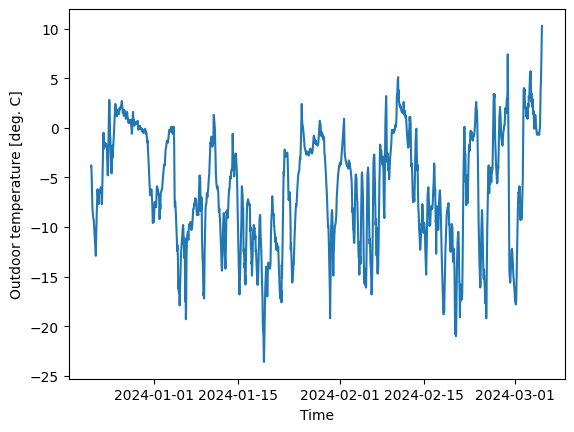

In [95]:
plt.clf()
plt.plot(convert_datetime(df[xdata_lbl]), df[ydata_lbl],)
plt.xlabel(xdata_lbl)
plt.ylabel(ydata_lbl)
plt.show()

In [137]:
def df_filter_fct(
        id_list=[i+1 for i in range(29)], 
        heights="lmh"
        ):
    """
    Prend le dataframe au complet, et sort un nouveau df contenant uniquement les capteur spécifié
    On peut spécifier le id du capteur (1 à 29) avec une liste de int
    On peut spécifier low, mid ou high avec un str (s'il contient L et/ou M et/ou H)
    """

    # reject ids above 29
    id_list = sorted([i for i in id_list if i < 30])

    # initialise lists
    corrected_id_low, corrected_id_mid, corrected_id_high = [], [], []
    if "l" in heights or "L" in heights:
        corrected_id_low  = [i + 2 for i in id_list]
    if "m" in heights or "M" in heights:
        corrected_id_mid  = [i + 29 + 2 for i in id_list]
    if "h" in heights or "H" in heights:
        corrected_id_high = [i + 2*29 + 2 for i in id_list]

    # Filter df
    return df.iloc[:,[*corrected_id_low, *corrected_id_mid, *corrected_id_high]]

def plot_sensors(id_list=[i+1 for i in range(29)], heights="lmh"):
    # Get filtered df
    df_f = df_filter_fct(id_list, heights)
    plt.clf()
    for sensor in df_f.columns[:]:
        plt.plot(convert_datetime(df["Time"]), df[sensor],)
    plt.xlabel(xdata_lbl)
    plt.ylabel(ydata_lbl)
    plt.show()
    return


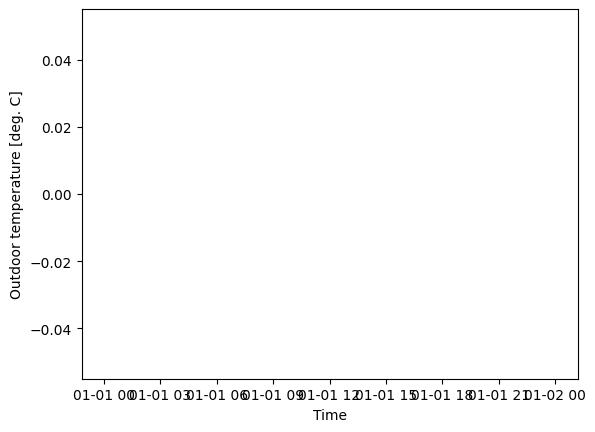

In [ ]:
# Test de graphs
sensor_list = [2]
plot_sensors(sensor_list, heights='lh')

In [161]:
# On veut compute l'écart moyen et/ou médian entre low mid et high pour chaque cellule
P1 = [1, 2, 3, 4, 5]
P2 = [5, 6, 7, 8, 9]
P3 = [9, 10, 11, 12, 13]
P4 = [13, 14, 15, 16, 17, 18, 19]
P5 = [19, 20, 21, 22, 23]
P6 = [23, 24, 25, 26, 27, 28, 29]

def lmh_stats(P):
    #get filtered dataframe
    df_low = df_filter_fct(P, heights='L')
    df_mid = df_filter_fct(P, heights='m')
    df_high = df_filter_fct(P, heights='h')

    # compute la différence  moyenne
    for i, id in enumerate(df_low.columns[:]):
        ecart = df_high.iloc[:,i] - df_low.iloc[:, i]
        print(f"{str(id)[12:]}: Mean = {ecart.mean():.2f}, Med = {ecart.median():.2f}, Std = {ecart.std():.2f}")
    return
lmh_stats(P1)

S1: Mean = 0.94, Med = 1.36, Std = 1.77
S2: Mean = 3.85, Med = 4.54, Std = 1.99
S3: Mean = 7.65, Med = 8.72, Std = 3.84
S4: Mean = 2.54, Med = 2.86, Std = 1.37
S5: Mean = nan, Med = nan, Std = nan


C:\Users\Mathieu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
